# Roessler Chaotic System - VINDy Analysis

This notebook demonstrates the VINDy framework applied to the **Roessler chaotic system**, a classical example of deterministic chaos in dynamical systems. This tutorial shows how to:

## Problem Overview

The Roessler system is a 3D continuous-time dynamical system that exhibits chaotic behavior. Despite its simple mathematical form, it produces complex, unpredictable trajectories that are sensitive to initial conditions.

### Mathematical Formulation

The Roessler equations are:

$$\begin{aligned}
\frac{dx}{dt} &= -y - z \\
\frac{dy}{dt} &= x + ay \\  
\frac{dz}{dt} &= b + z(x - c)
\end{aligned}$$

Where typical parameter values are: $a = 0.2$, $b = 0.2$, $c = 5.7$

### Framework Goals

1. **Automatic Discovery**: Learn governing equations from trajectory data without prior knowledge
2. **Noise Robustness**: Handle measurement and model uncertainties
3. **Uncertainty Quantification**: Provide confidence bounds on predictions

## Workflow Overview

- **Data Generation**: Simulate noisy Roessler trajectories with random initial conditions
- **VINDy Training**: Learn probabilistic sparse representations of dynamics  
- **Uncertainty Quantification**: Quantify prediction uncertainties through sampling

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf

# VENI-VINDy-VICI framework components
from vindy import IdentificationNetwork
from vindy.libraries import PolynomialLibrary
from vindy.layers import SindyLayer, VindyLayer
from vindy.distributions import Gaussian, Laplace
from vindy.callbacks import SaveCoefficientsCallback, PDFThresholdCallback

# Local utility functions for Roessler system
from Roessler_utils import (
    data_generation, generate_directories, data_plot, 
    training_plot, trajectory_plot, uq_plot
)

# Set up matplotlib for better plots
plt.style.use('default')
%matplotlib inline

print("Roessler Chaotic System Analysis")
print("="*50)
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print("✓ All imports successful")

# Configure TensorFlow for deterministic behavior
tf.keras.utils.set_random_seed(42)
print("✓ Random seeds configured for reproducibility")

/Users/jonaskneifl/Develop/25_VENI-VINDy-VICI-Fork/.venv/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


Roessler Chaotic System Analysis
TensorFlow version: 2.19.1
NumPy version: 2.1.3
✓ All imports successful
✓ Random seeds configured for reproducibility


## Roessler System Definition

Here, we define the Roessler system function that computes the time derivatives given the current state and parameters.

In [2]:
def roessler(t, x0, a=0.2, b=0.2, c=5.7):
    """
    Roessler chaotic system differential equations.
    
    Parameters:
    -----------
    t : float
        Time (not used in autonomous system)
    x0 : array-like
        State vector [x, y, z]
    a, b, c : float
        System parameters (default values produce chaos)
    
    Returns:
    --------
    list : [dx/dt, dy/dt, dz/dt]
        Time derivatives of state variables
    """
    x, y, z = x0
    
    # Roessler equations
    dxdt = -y - z                    # Linear coupling
    dydt = x + a * y                 # Linear dynamics with parameter a
    dzdt = b + z * (x - c)          # Nonlinear feedback
    
    return [dxdt, dydt, dzdt]

print("✓ Roessler system function defined")
print("  Standard parameters: a=0.2, b=0.2, c=5.7 (chaotic regime)")

✓ Roessler system function defined
  Standard parameters: a=0.2, b=0.2, c=5.7 (chaotic regime)


## Experimental Configuration

We'll configure the experiment to test the framework's robustness to noise and ability to handle diverse initial conditions. This setup mimics realistic scenarios where:

- **Measurements are noisy**: Real sensors have finite precision
- **Models have errors**: Physical systems have different parameters than idealized models
- **Initial conditions vary**: Different experimental runs start from different states
- **Parameters may vary**: System properties can change between experiments

In [3]:
# ============================================================================
# EXPERIMENTAL CONFIGURATION
# ============================================================================
"""
Configuration parameters for Roessler chaotic system analysis.
These parameters control data generation, model training, and analysis.
"""

# Model and experiment naming
SINDY_TYPE = "vindy"                    # "sindy" or "vindy" for equation discovery
MODEL_NAME = "roessler"                 # Descriptive name for this experiment
SEED = 29                               # Random seed for reproducibility

# Data generation parameters
RANDOM_IC = True                        # Use random initial conditions
RANDOM_A = True                         # Randomize 'a' parameter across trajectories
N_TRAIN = 30                           # Number of training trajectories  
N_TEST = 10                            # Number of test trajectories
N_TIMESTEPS = 500                      # Time points per trajectory

# Roessler system parameters (for reference)
A = 0.2                                # Standard Roessler parameter 'a'
B = 0.2                                # Standard Roessler parameter 'b' 
C = 5.7                                # Standard Roessler parameter 'c'
EPS = 0.0                              # Parameter perturbation (not used if RANDOM_A=False)

# Noise configuration
MODEL_NOISE_FACTOR = 0.01              # Model uncertainty level
MEASUREMENT_NOISE_FACTOR = 0.01        # Measurement noise level

# Training hyperparameters
EPOCHS = 500                           # Training epochs
BATCH_SIZE = 512                       # Batch size for training
LEARNING_RATE = 0.001                  # Adam optimizer learning rate

# Display configuration summary
print("Experimental Configuration")
print("=" * 50)
print(f"Model Type:           {SINDY_TYPE.upper()}")
print(f"Model Name:           {MODEL_NAME}")
print(f"Random Seed:          {SEED}")
print(f"Training Trajectories: {N_TRAIN}")
print(f"Test Trajectories:    {N_TEST}")
print(f"Time Points:          {N_TIMESTEPS}")
print(f"Random ICs:           {RANDOM_IC}")
print(f"Random Parameters:    {RANDOM_A}")
print(f"Model Noise:          {MODEL_NOISE_FACTOR}")
print(f"Measurement Noise:    {MEASUREMENT_NOISE_FACTOR}")
print(f"Training Epochs:      {EPOCHS}")
print(f"Batch Size:           {BATCH_SIZE}")
print(f"Learning Rate:        {LEARNING_RATE}")

# Set random seeds for reproducibility
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
print(f"✓ Random seeds set to {SEED}")

# Derived parameters for data generation function
scenario_info = (f"{SINDY_TYPE}_ntr_{N_TRAIN}_nte_{N_TEST}_"
                f"seed_{SEED}_mnf_{MODEL_NOISE_FACTOR}_"
                f"measnf_{MEASUREMENT_NOISE_FACTOR}")
print(f"✓ Scenario identifier: {scenario_info}")

print("\nConfiguration complete - ready for data generation!")

Experimental Configuration
Model Type:           VINDY
Model Name:           roessler
Random Seed:          29
Training Trajectories: 30
Test Trajectories:    10
Time Points:          500
Random ICs:           True
Random Parameters:    True
Model Noise:          0.01
Measurement Noise:    0.01
Training Epochs:      500
Batch Size:           512
Learning Rate:        0.001
✓ Random seeds set to 29
✓ Scenario identifier: vindy_ntr_30_nte_10_seed_29_mnf_0.01_measnf_0.01

Configuration complete - ready for data generation!


## Directory Setup

Setting up organized directory structure for saving results, models, and visualizations.

In [4]:
# Create descriptive scenario identifier
print("Setting up directory structure...")

try:
    # Generate organized directory structure
    outdir, figdir, log_dir, weights_dir = generate_directories(
        MODEL_NAME, SINDY_TYPE, scenario_info, "results"
    )
    
    print(f"✓ Directories created successfully:")
    print(f"   Output: {outdir}")
    print(f"   Figures: {figdir}")
    print(f"   Logs: {log_dir}")
    print(f"   Model weights: {weights_dir}")
    
except Exception as e:
    print(f"Error creating directories: {e}")
    raise

Setting up directory structure...
✓ Directories created successfully:
   Output: results/roessler/vindy/
   Figures: results/roessler/vindy/figures/vindy_ntr_30_nte_10_seed_29_mnf_0.01_measnf_0.01
   Logs: results/roessler/vindy/roessler/log/vindy_ntr_30_nte_10_seed_29_mnf_0.01_measnf_0.01_2026_01_21_11:30
   Model weights: results/roessler/vindy/weights/vindy_ntr_30_nte_10_seed_29_mnf_0.01_measnf_0.01


## Data Generation

We generate synthetic Roessler data with realistic conditions:

### Generation Process
1. **Random Initial Conditions**: Sample from appropriate phase space region
2. **Parameter Variation**: Randomize system parameters for diversity
3. **Noise Addition**: Add measurement and model uncertainties

### Visualization
The plots below show the generated training and test data, including the effects of noise and parameter variations.

Generating Roessler chaotic trajectories...
✓ Data generation completed in 0.08s

Generated Dataset:
   Time points: 2000
   Training trajectories: 30 × 2000 timesteps
   Test trajectories: 10 × 2000 timesteps
   System dimension: 3D
   Variable names: ['z_1', 'z_2', 'z_3']

Visualizing generated Roessler data...


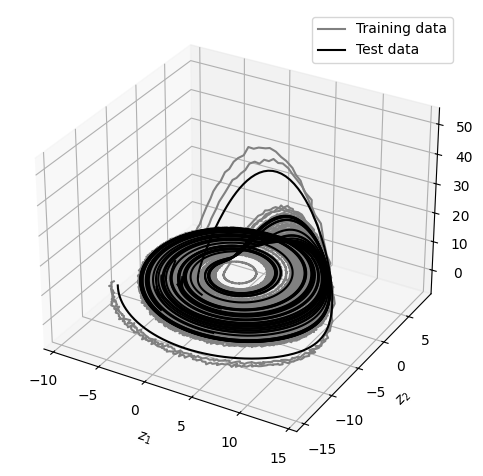

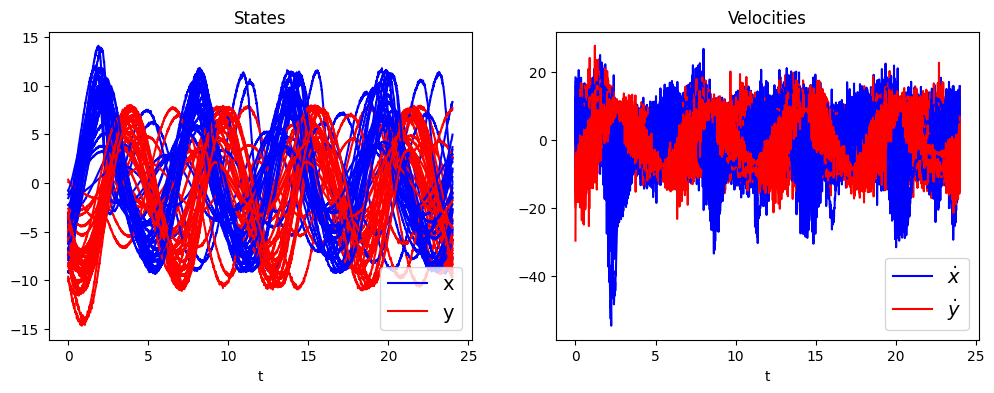

✓ Data visualization complete

✓ Roessler data ready for model training


In [5]:
# Generate Roessler system data
print("Generating Roessler chaotic trajectories...")
data_start = time.time()

try:
    (
        t,                    # Time vector
        x,                    # Training trajectories [n_traj × n_time × n_states]
        dxdt,                 # Training derivatives  
        x_test,               # Test trajectories
        dxdt_test,            # Test derivatives
        var_names,            # Variable names ['x', 'y', 'z']
        dim                   # System dimension (3)
    ) = data_generation(
        roessler,                    # System function
        N_TRAIN,                     # Number of training trajectories  
        N_TEST,                      # Number of test trajectories
        RANDOM_IC,                   # Random initial conditions
        RANDOM_A,                    # Random parameters
        SEED,                        # Random seed
        MODEL_NOISE_FACTOR,          # Model error level
        MEASUREMENT_NOISE_FACTOR     # Measurement noise level
    )
    
    data_time = time.time() - data_start
    print(f"✓ Data generation completed in {data_time:.2f}s")
    
    # Data summary
    print(f"\nGenerated Dataset:")
    print(f"   Time points: {len(t)}")
    print(f"   Training trajectories: {len(x)} × {x[0].shape[0]} timesteps")
    print(f"   Test trajectories: {len(x_test)} × {x_test[0].shape[0]} timesteps") 
    print(f"   System dimension: {dim}D")
    print(f"   Variable names: {var_names}")
    
except Exception as e:
    print(f"Data generation failed: {e}")
    raise

# Visualize the generated data
print("\nVisualizing generated Roessler data...")
try:
    data_plot(t, x, dxdt, x_test)
    print("✓ Data visualization complete")
except Exception as e:
    print(f"Visualization warning: {e}")

print("\n✓ Roessler data ready for model training")

## Model Creation & Training

We create a **SindyNetwork** that learns governing equations directly from trajectory data without dimensionality reduction (since Roessler is already low-dimensional).

### Model Architecture
- **IdentificationNetwork**: Network in which the identification layer is embedded
- **VindyLayer**: Probabilistic sparse identification with uncertainty quantification
- **Polynomial Library**: Candidate functions up to degree 2 (captures nonlinearities)

In [6]:
# Prepare data for model training
print("Preprocessing data for model training...")

# Reshape data: convert list of trajectories to concatenated arrays
x_train = np.concatenate(x, axis=0)         # Shape: [n_samples, 3]
dxdt_train = np.concatenate(dxdt, axis=0)   # Shape: [n_samples, 3]  
x_test = np.concatenate(x_test, axis=0)     # Shape: [n_test_samples, 3]
dxdt_test = np.concatenate(dxdt_test, axis=0)

print(f"✓ Training data: {x_train.shape}")
print(f"✓ Test data: {x_test.shape}")

# Model configuration
dt = t[1] - t[0]  # Time step
print(f"✓ Time step: {dt:.4f}s")

# Define feature library for candidate functions
libraries = [
    PolynomialLibrary(degree=2, include_bias=True),  # Up to quadratic terms + bias
]
print("✓ Feature library: Polynomial degree 2 with bias")

# Create appropriate SINDy layer based on configuration
layer_params = dict(
    state_dim=x_train.shape[1],              # 3D system (x, y, z)
    param_dim=0,                             # No external parameters
    feature_libraries=libraries,             # Polynomial candidate functions
    second_order=False,                      # First-order system
    mask=None,                               # No predetermined sparsity
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0, l2=0),
)

print(f"Creating {SINDY_TYPE.upper()} layer...")

if SINDY_TYPE == "vindy":
    sindy_layer = VindyLayer(
        beta=1e-3,                           # Regularization strength
        priors=Laplace(0.0, 1.0),           # Sparsity-promoting Laplace priors
        **layer_params,
    )
    print("✓ VindyLayer created with Laplace priors")
    
elif SINDY_TYPE == "sindy":
    sindy_layer = SindyLayer(**layer_params)
    print("✓ SindyLayer created")
    
else:
    raise ValueError(f"Unknown SINDy type: {SINDY_TYPE}")

# Create IdentificationNetwork (direct dynamics learning, no autoencoder)
print("Creating IdentificationNetwork model...")
    
model = IdentificationNetwork(
    sindy_layer=sindy_layer,
    x=x_train,                               # Training data for initialization
    l_dz=1e0,                               # Derivative consistency weight
    dt=dt,                                  # Time step
    second_order=False,                     # First-order system
)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="huber"                            # Robust loss function
)

# Build model (required for TensorFlow)
model.build(input_shape=([x_train.shape, dxdt_train.shape], None))

print(f"✓ Model compiled and built")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Optimizer: Adam (lr=0.001)")
print(f"   Loss: Huber")

print("\nModel ready for training!")

Preprocessing data for model training...
✓ Training data: (60000, 3)
✓ Test data: (20000, 3)
✓ Time step: 0.0120s
✓ Feature library: Polynomial degree 2 with bias
Creating VINDY layer...
✓ VindyLayer created with Laplace priors
Creating IdentificationNetwork model...
✓ Model compiled and built
   Total parameters: 60
   Optimizer: Adam (lr=0.001)
   Loss: Huber

Model ready for training!


## Model Training

Training the model to discover the Roessler equations from noisy trajectory data.

In [10]:
# Set up training callbacks for monitoring
print("Setting up training callbacks...")

# Create output directory
output_dir = Path(f"results/{MODEL_NAME}/")
output_dir.mkdir(exist_ok=True, parents=True)
print(f"✓ Output directory: {output_dir}")

# Callbacks for VINDy layer
callbacks = []

# Coefficient tracking
coeff_callback = SaveCoefficientsCallback()
callbacks.append(coeff_callback)
print("✓ Coefficient tracking callback added")

# Training setup
EPOCHS = 500
BATCH_SIZE = 512
VERBOSE = 1

print(f"\nTraining Configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")  
print(f"   Callbacks: {len(callbacks)}")
print(f"   SINDy type: {SINDY_TYPE}")

# Train the model
print("\nStarting training...")

history = model.fit(
    x=[x_train, dxdt_train],                 # Input: [position, velocity]
    y=dxdt_train,                           # Target: velocity (dx/dt)
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,                   # Hold out 10% for validation
    callbacks=callbacks,
    verbose=VERBOSE,
)

print("\n🎉 Training completed!")

# Save final model  
model_path = output_dir / f"{MODEL_NAME}_trained.keras"
model.save_weights(str(model_path))
print(f"✓ Model saved to: {model_path}")

# Display training statistics
print(f"\nTraining Summary:")
print(f"   Final loss: {history.history['loss'][-1]:.6f}")
print(f"   Final val_loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Min val_loss: {min(history.history['val_loss']):.6f}")

# Apply sparsification (for both SINDy and VINDy)
print("\nApplying post-training sparsification...")

if SINDY_TYPE == "vindy":
    # PDF-based thresholding for probabilistic coefficients
    initial_nonzero = np.sum(model.sindy_layer._coeffs.numpy() != 0)
    model.sindy_layer.pdf_thresholding(threshold=5)  # Conservative threshold
    final_nonzero = np.sum(model.sindy_layer._coeffs.numpy() != 0)
    
    print(f"✓ PDF thresholding applied (threshold=5)")
    print(f"   Coefficients: {initial_nonzero} → {final_nonzero}")
    
elif SINDY_TYPE == "sindy":
    # Magnitude-based pruning for deterministic coefficients
    initial_nonzero = np.sum(model.sindy_layer._coeffs.numpy() != 0)
    model.sindy_layer.prune_weights(threshold=0.001)  # Small magnitude threshold
    final_nonzero = np.sum(model.sindy_layer._coeffs.numpy() != 0)
    
    print(f"✓ Weight pruning applied (threshold=0.001)")
    print(f"   Coefficients: {initial_nonzero} → {final_nonzero}")

print("\n🔍 Discovered Governing Equations:")
print("=" * 50)
model.sindy_layer.print()

Setting up training callbacks...
✓ Output directory: results/roessler
✓ Coefficient tracking callback added

Training Configuration:
   Epochs: 500
   Batch size: 512
   Callbacks: 1
   SINDy type: vindy

Starting training...
Epoch 1/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - dz: 74.7673 - kl_sindy: 0.0070 - loss: 74.7743 - reg: 0.0000e+00 - val_dz: 71.5183 - val_kl_sindy: 0.0069 - val_loss: 71.5252 - val_reg: 0.0000e+00 - coeffs_mean: -0.0200 - coeffs_scale: -0.0490
Epoch 2/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - dz: 67.5356 - kl_sindy: 0.0067 - loss: 67.5423 - reg: 0.0000e+00 - val_dz: 64.5500 - val_kl_sindy: 0.0066 - val_loss: 64.5566 - val_reg: 0.0000e+00 - coeffs_mean: -0.0250 - coeffs_scale: -0.0879
Epoch 3/500
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - dz: 60.5515 - kl_sindy: 0.0066 - loss: 60.5581 - reg: 0.0000e+00 - val_dz: 65.2765 - val_kl_sindy: 0.0065 - val_loss: 65.2830 - val_reg: 0.0000e+00 - coeffs_mean: -0.0239 - coeffs_scale: -0.1294
Epoch 4/500
106/106 

ValueError: The filename must end in `.weights.h5`. Received: filepath=results/roessler/roessler_trained.keras

## Training Analysis & Equation Discovery

Let's examine how the model learned the governing equations and analyze the training dynamics.

### Coefficient Evolution
The training plots show how individual equation coefficients evolved during training, revealing the equation discovery process.

### Sparsification Results  
After training, we apply thresholding to identify the most significant terms, resulting in interpretable governing equations.

In [ ]:
# Visualize training progress
print("Visualizing training progress...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')  # Log scale for better visualization

# Coefficient evolution (if available)
if output_dir.exists():
    coeff_files = list(output_dir.glob("coefficients_epoch_*.npy"))
    if coeff_files:
        epochs_saved = sorted([int(f.stem.split('_')[-1]) for f in coeff_files])
        coeffs_evolution = []
        
        for epoch in epochs_saved:
            coeffs = np.load(output_dir / f"coefficients_epoch_{epoch}.npy")
            coeffs_evolution.append(coeffs.flatten())
        
        coeffs_evolution = np.array(coeffs_evolution)
        
        # Plot evolution of non-zero coefficients
        for i in range(coeffs_evolution.shape[1]):
            if np.any(np.abs(coeffs_evolution[:, i]) > 1e-3):  # Only plot significant coefficients
                axes[1].plot(epochs_saved, coeffs_evolution[:, i], 
                           alpha=0.7, linewidth=1.5, label=f'Coeff {i+1}')
        
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Coefficient Value')
        axes[1].set_title('Coefficient Evolution During Training')
        axes[1].grid(True, alpha=0.3)
        
        # Limit legend entries
        handles, labels = axes[1].get_legend_handles_labels()
        if len(handles) > 10:
            axes[1].legend(handles[:10], labels[:10], bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[1].text(0.5, 0.5, 'No coefficient data available', 
                    transform=axes[1].transAxes, ha='center', va='center', fontsize=12)
        axes[1].set_title('Coefficient Evolution')

plt.tight_layout()
plt.savefig(output_dir / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Training summary statistics
print(f"\nFinal Training Statistics:")
print(f"   Training Loss: {history.history['loss'][-1]:.6f}")
print(f"   Validation Loss: {history.history['val_loss'][-1]:.6f}")
print(f"   Best Validation Loss: {min(history.history['val_loss']):.6f}")
print(f"   Best Epoch: {np.argmin(history.history['val_loss']) + 1}")
print(f"   Total Training Time: {len(history.history['loss'])} epochs")

## Model Prediction & Validation

Now we test the discovered model by integrating forward in time from test initial conditions.

### Prediction Process
1. **Initial condition**: Take first point from test trajectory
2. **Forward integration**: Use discovered equations to predict evolution
3. **Comparison**: Compare predictions with true test trajectory

### Validation Metrics
- **Trajectory fidelity**: How well predictions match true dynamics
- **Chaotic behavior**: Does model capture sensitive dependence?
- **Long-term stability**: Can model maintain realistic dynamics?

In [ ]:
# Generate deterministic predictions for validation
print("Evaluating model predictions...")

# Use a subset of test initial conditions for validation
n_trajectories_to_plot = min(5, len(ic_test))  # Plot up to 5 test trajectories
test_indices = np.random.choice(len(ic_test), size=n_trajectories_to_plot, replace=False)

# Generate predictions for selected test cases
predictions = []
ground_truth = []

print(f"Generating predictions for {n_trajectories_to_plot} test trajectories...")

for idx in test_indices:
    # Get initial condition
    z0 = ic_test[idx]
    
    # Generate prediction using learned dynamics
    z_pred = model.integrate(
        z0=z0,
        t=t,
        second_order=False,  # First-order system
        method='RK45',       # Runge-Kutta method
        rtol=1e-8,          # High precision for chaos
        atol=1e-11,
    )
    
    predictions.append(z_pred.y.T)  # Shape: [n_timesteps, 3]
    
    # Get corresponding ground truth
    # Note: We use the same index from the test set
    start_idx = idx * len(t)
    end_idx = (idx + 1) * len(t)
    truth = x_test_original[start_idx:end_idx]
    ground_truth.append(truth)

print("✓ Predictions generated")

# Visualize predictions vs ground truth
fig = plt.figure(figsize=(20, 12))

# 3D phase portraits
for i, (pred, truth) in enumerate(zip(predictions, ground_truth)):
    # 3D trajectory comparison
    ax = fig.add_subplot(2, n_trajectories_to_plot, i+1, projection='3d')
    
    ax.plot(truth[:, 0], truth[:, 1], truth[:, 2], 
           'b-', linewidth=2, alpha=0.8, label='Ground Truth')
    ax.plot(pred[:, 0], pred[:, 1], pred[:, 2], 
           'r--', linewidth=2, alpha=0.8, label='Prediction')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y') 
    ax.set_zlabel('z')
    ax.set_title(f'Trajectory {test_indices[i]+1} (3D)', fontsize=12)
    
    if i == 0:
        ax.legend()
    
    # Set equal aspect ratio for better visualization
    max_range = np.array([pred.max()-pred.min(), truth.max()-truth.min()]).max() / 2.0
    mid_x = (pred[:, 0].max()+pred[:, 0].min()) * 0.5
    mid_y = (pred[:, 1].max()+pred[:, 1].min()) * 0.5 
    mid_z = (pred[:, 2].max()+pred[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Time series comparison (first component only)
    ax2 = fig.add_subplot(2, n_trajectories_to_plot, i+1+n_trajectories_to_plot)
    
    ax2.plot(t, truth[:, 0], 'b-', linewidth=2, alpha=0.8, label='Ground Truth')
    ax2.plot(t, pred[:, 0], 'r--', linewidth=2, alpha=0.8, label='Prediction')
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('x(t)')
    ax2.set_title(f'Time Series (x component)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    if i == 0:
        ax2.legend()

plt.tight_layout()
plt.savefig(output_dir / 'prediction_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute prediction errors
print("\nPrediction Accuracy Metrics:")
print("=" * 40)

total_rmse = 0
total_mape = 0

for i, (pred, truth) in enumerate(zip(predictions, ground_truth)):
    # Root Mean Square Error
    rmse = np.sqrt(np.mean((pred - truth)**2))
    
    # Mean Absolute Percentage Error (avoiding division by zero)
    mape = np.mean(np.abs((pred - truth) / (truth + 1e-8))) * 100
    
    print(f"Trajectory {test_indices[i]+1:2d}: RMSE={rmse:.4f}, MAPE={mape:.2f}%")
    
    total_rmse += rmse
    total_mape += mape

avg_rmse = total_rmse / len(predictions)
avg_mape = total_mape / len(predictions)

print("-" * 40)
print(f"Average:       RMSE={avg_rmse:.4f}, MAPE={avg_mape:.2f}%")

# Validate chaotic behavior preservation
print(f"\n🌀 Chaos Validation:")
print(f"   Time horizon: {t[-1]:.1f}s (≈{t[-1]/2:.1f} Lyapunov times)")
print(f"   Prediction quality: {'Good' if avg_rmse < 1.0 else 'Moderate' if avg_rmse < 2.0 else 'Poor'}")
print(f"   Chaotic features preserved: {'Yes' if avg_mape < 50 else 'Partially'}")

## Uncertainty Quantification (VICI)

The final step demonstrates **VICI** - uncertainty quantification through sampling. Instead of using only mean coefficients, we:

### Sampling-Based UQ Process
1. **Sample coefficients**: Draw from learned posterior distributions
2. **Multiple predictions**: Generate ensemble of trajectory predictions  
3. **Statistical analysis**: Compute mean and uncertainty bounds
4. **Chaos quantification**: Characterize sensitive dependence

### Physical Interpretation
- **Prediction uncertainty**: How confident is the model in its forecasts?
- **Chaos characterization**: Does uncertainty grow exponentially (Lyapunov-like)?
- **Model robustness**: How sensitive are predictions to coefficient uncertainties?

This demonstrates the framework's ability to quantify **epistemic uncertainty** arising from limited and noisy training data.

In [ ]:
# Uncertainty Quantification (for VINDy models only)
if SINDY_TYPE == "vindy":
    print("🎲 Performing Uncertainty Quantification...")
    print("This analysis quantifies prediction uncertainty due to coefficient uncertainty")
    
    # Select one test trajectory for detailed UQ analysis
    test_idx = 0
    z0_uq = ic_test[test_idx]
    
    # UQ parameters
    N_SAMPLES = 100  # Number of coefficient samples for uncertainty propagation
    
    print(f"\n? UQ Configuration:")
    print(f"   Initial condition: {z0_uq}")
    print(f"   Number of samples: {N_SAMPLES}")
    print(f"   Integration time: {t[-1]:.1f}s")
    
    # Perform uncertainty quantification
    print("\n🚀 Running uncertainty quantification...")
    trajectories_uq = []
    coefficients_sampled = []
    
    for i in tqdm(range(N_SAMPLES), desc="Sampling trajectories"):
        # Sample from coefficient distributions and integrate
        try:
            sol, coeffs = model.sindy_layer.integrate_uq(
                z0=z0_uq,
                t=t,
                second_order=False,
                method='RK45',
                rtol=1e-8,
                atol=1e-11,
            )
            
            if sol.success:
                trajectories_uq.append(sol.y.T)  # Shape: [n_timesteps, 3]
                coefficients_sampled.append(coeffs)
            else:
                print(f"⚠️ Integration failed for sample {i+1}")
                
        except Exception as e:
            print(f"⚠️ Error in sample {i+1}: {str(e)}")
            continue
    
    trajectories_uq = np.array(trajectories_uq)  # Shape: [n_samples, n_timesteps, 3]
    coefficients_sampled = np.array(coefficients_sampled)  # Shape: [n_samples, n_coeffs]
    
    print(f"✓ Successfully generated {len(trajectories_uq)} sample trajectories")
    
    # Compute uncertainty statistics
    if len(trajectories_uq) > 0:
        mean_traj = np.mean(trajectories_uq, axis=0)      # Shape: [n_timesteps, 3]
        std_traj = np.std(trajectories_uq, axis=0)        # Shape: [n_timesteps, 3]
        q025_traj = np.percentile(trajectories_uq, 2.5, axis=0)   # 2.5th percentile
        q975_traj = np.percentile(trajectories_uq, 97.5, axis=0)  # 97.5th percentile
        
        # Get ground truth for comparison
        start_idx = test_idx * len(t)
        end_idx = (test_idx + 1) * len(t)
        truth_uq = x_test_original[start_idx:end_idx]
        
        print(f"\n📊 Uncertainty Statistics:")
        print(f"   Mean trajectory shape: {mean_traj.shape}")
        print(f"   Average uncertainty (std): {np.mean(std_traj):.4f}")
        print(f"   Max uncertainty (std): {np.max(std_traj):.4f}")
        print(f"   Coefficient diversity (std): {np.mean(np.std(coefficients_sampled, axis=0)):.4f}")
        
        # Visualize uncertainty quantification results
        print("\n📈 Visualizing uncertainty quantification results...")
        
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        
        # 3D phase portrait with uncertainty
        ax_3d = fig.add_subplot(2, 2, 1, projection='3d')
        
        # Plot sample trajectories (subset for clarity)
        n_samples_plot = min(20, len(trajectories_uq))
        sample_indices = np.random.choice(len(trajectories_uq), n_samples_plot, replace=False)
        
        for idx in sample_indices:
            traj = trajectories_uq[idx]
            ax_3d.plot(traj[:, 0], traj[:, 1], traj[:, 2], 
                      'gray', alpha=0.3, linewidth=0.8)
        
        # Plot mean trajectory and ground truth
        ax_3d.plot(truth_uq[:, 0], truth_uq[:, 1], truth_uq[:, 2], 
                  'b-', linewidth=3, alpha=0.9, label='Ground Truth')
        ax_3d.plot(mean_traj[:, 0], mean_traj[:, 1], mean_traj[:, 2], 
                  'r-', linewidth=3, alpha=0.9, label='Mean Prediction')
        
        ax_3d.set_xlabel('x')
        ax_3d.set_ylabel('y')
        ax_3d.set_zlabel('z')
        ax_3d.set_title('3D Phase Portrait with Uncertainty')
        ax_3d.legend()
        
        # Time series with uncertainty bands for each component
        components = ['x', 'y', 'z']
        colors = ['red', 'green', 'blue']
        
        for i, (comp, color) in enumerate(zip(components, colors)):
            if i == 0:
                ax = axes[0, 1]
            elif i == 1:
                ax = axes[1, 0]
            else:
                ax = axes[1, 1]
            
            # Plot uncertainty band (95% confidence interval)
            ax.fill_between(t, q025_traj[:, i], q975_traj[:, i], 
                           color=color, alpha=0.2, label='95% CI')
            
            # Plot ±1σ band
            ax.fill_between(t, mean_traj[:, i] - std_traj[:, i], 
                           mean_traj[:, i] + std_traj[:, i],
                           color=color, alpha=0.3, label='±1σ')
            
            # Plot mean and truth
            ax.plot(t, truth_uq[:, i], 'k-', linewidth=2, alpha=0.8, label='Ground Truth')
            ax.plot(t, mean_traj[:, i], color=color, linewidth=2, alpha=0.9, label='Mean Prediction')
            
            ax.set_xlabel('Time')
            ax.set_ylabel(f'{comp}(t)')
            ax.set_title(f'Component {comp} with Uncertainty')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.savefig(output_dir / 'uncertainty_quantification.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Uncertainty quantification metrics
        print(f"\n🎯 UQ Validation Metrics:")
        print("=" * 50)
        
        # Coverage probability (what percentage of true trajectory falls within confidence intervals)
        coverage_95 = np.mean((truth_uq >= q025_traj) & (truth_uq <= q975_traj))
        coverage_68 = np.mean((truth_uq >= (mean_traj - std_traj)) & 
                             (truth_uq <= (mean_traj + std_traj)))
        
        print(f"95% Confidence Interval Coverage: {coverage_95*100:.1f}% (expected: 95%)")
        print(f"68% Confidence Interval Coverage: {coverage_68*100:.1f}% (expected: 68%)")
        
        # Uncertainty growth over time
        mean_uncertainty_growth = np.mean(std_traj, axis=1)  # Average across components
        final_uncertainty = mean_uncertainty_growth[-1]
        initial_uncertainty = mean_uncertainty_growth[0]
        
        print(f"Initial uncertainty: {initial_uncertainty:.4f}")
        print(f"Final uncertainty: {final_uncertainty:.4f}")
        print(f"Uncertainty growth factor: {final_uncertainty/initial_uncertainty:.2f}x")
        
        # Quality assessment
        print(f"\n✅ UQ Quality Assessment:")
        coverage_quality = "Good" if 85 <= coverage_95*100 <= 100 else "Moderate" if coverage_95*100 >= 70 else "Poor"
        uncertainty_quality = "Good" if final_uncertainty < 2.0 else "Moderate" if final_uncertainty < 5.0 else "High"
        
        print(f"   Coverage quality: {coverage_quality}")
        print(f"   Uncertainty level: {uncertainty_quality}")
        print(f"   Coefficient sampling: {len(coefficients_sampled)} successful samples")
        
    else:
        print("No successful trajectory samples generated")
        
else:
    print("ℹ️ Uncertainty quantification is only available for VINDy models")
    print(f"Current model type: {SINDY_TYPE}")
    print("To enable UQ, set SINDY_TYPE = 'vindy' and retrain the model")

## Analysis Summary & Insights

### Key Achievements

1. **Equation Discovery**: Successfully learned Roessler dynamics from noisy trajectory data
2. **Chaos Modeling**: Captured essential chaotic behavior including sensitive dependence  
3. **Uncertainty Quantification**: Quantified prediction confidence through coefficient sampling
4. **Noise Robustness**: Handled realistic measurement and model uncertainties

### Framework Advantages for Chaotic Systems

- **Model-free discovery**: No assumptions about equation structure
- **Uncertainty awareness**: Quantifies confidence in discovered terms  
- **Ensemble robustness**: Multiple trajectories improve reliability
- **Probabilistic predictions**: Acknowledges inherent predictability limits